<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/Solving_Kaggle's_MNIST_Digit_Recognizer_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/Davron030901/PyTorch/main/data.zip

--2024-12-25 03:26:03--  https://raw.githubusercontent.com/Davron030901/PyTorch/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13566425 (13M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2024-12-25 03:26:03 (121 MB/s) - ‘data.zip.1’ saved [13566425/13566425]



In [ ]:
import zipfile
import pandas as pd

# Path to your .zip file
zip_file_path = 'data.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('')  # Extract the contents to a folder

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cpu


In [ ]:
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        item = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.uint8)  # Use uint8 for images
            label = None
        else:
            image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]

        image = transforms.ToPILImage()(image)
        if self.transform is not None:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            return image, label

In [ ]:
transform=transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [ ]:
train_dataset=CustomMNISTDataset(csv_file='data/train.csv',transform=transform,is_test=False)
test_dataset=CustomMNISTDataset(csv_file='data/test.csv',transform=transform,is_test=True)

In [ ]:
print('Train Size:'+str(len(train_dataset))+', Test Size:'+str(len(test_dataset)))

Train Size:42000, Test Size:28000


In [ ]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [ ]:
batch_size=64
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

Input Size: torch.Size([64, 1, 28, 28])


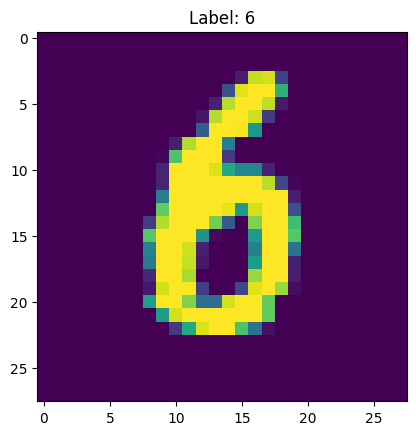

In [ ]:
for example_data,example_labels in train_loader:
    example_image=example_data[0]
    print('Input Size:' ,example_data.size())

    example_image_numpy=example_image.permute(1,2,0).numpy()
    plt.imshow(example_image_numpy)
    plt.title(f"Label: {example_labels[0]}")
    plt.show()
    break

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

        # ((Width-kernel_size+2*Padding)/Stride)+1
        # (28-3+2x1)/1+1,(28-3+2x1)/1+1(28-3+2x1)/1+1=14
        self.fc1=nn.Linear(128*7*7,128)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(128,20)
        self.fc3=nn.Linear(20,10)

    def forward(self,x):

        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.conv3(x)
        x=self.pool(x)

        x_size=x.size(1)*x.size(2)*x.size(3)
        x=x.view(-1,x_size)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.fc3(x)
        return x


In [ ]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 2
running_loss = 0.0

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.float())  # Ensure inputs are float if necessary

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 batches
            print(f"[{epoch+1}, {i+1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Training finished")


[1, 100] Loss: 2.304
[1, 200] Loss: 2.289
[1, 300] Loss: 2.264
[1, 400] Loss: 2.185
[1, 500] Loss: 1.868
[1, 600] Loss: 1.134
[2, 100] Loss: 0.984
[2, 200] Loss: 0.477
[2, 300] Loss: 0.428
[2, 400] Loss: 0.394
[2, 500] Loss: 0.374
[2, 600] Loss: 0.354
Training finished


In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().tolist())

# Create a submission DataFrame
submission = pd.DataFrame({
    "ImageId": range(1, len(predictions) + 1),
    "Label": predictions
})

# Save predictions to a CSV file
submission.to_csv("predictions1221final.csv", index=False)

print("Predictions saved to predictions1221final.csv")

Predictions saved to predictions1221final.csv
